In [30]:
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from keras.utils.vis_utils import plot_model
from keras_radam import RAdam

from helpers import*

## Loading the dataset 

In [31]:
data = pd.read_csv('datasets/bank-additional-full.csv', sep=';')

# Neural Network

In [32]:
def run_benchmark(data, activation = 'selu', N_spec = 49):
    list_optimzers = ['adam', 'sgd', RAdam()]
    spects = np.linspace(0.5,0.99,N_spec)
    
    sgd_f1 = []
    adam_f1 = []
    radam_f1 = []
    
    sgd_precision = []
    adam_precision = []
    radam_precision = []
    
    sgd_recall = []
    adam_recall = []
    radam_recall = []
    
    for spect in spects:
        one_hot_enc = build_spectrum (data,do_spectrum = True ,spect = spect)
        X = one_hot_enc.drop(columns=['y'])
        y = one_hot_enc['y']
        X, y= build_keras (X,y)
        model = build_model(activation)
        for l in list_optimzers:
            # define 10-fold cross validation test harness
            kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            cvscores_f1 = []
            cvscores_precision = []
            cvscores_recall = []
            for train, test in kfold.split(X, y):
                model.compile(loss='binary_crossentropy', optimizer=l, metrics=[f1_m,precision_m, recall_m])
                model.fit(X[train], y[train], epochs=50, batch_size=10, verbose=0)
                # evaluate the model
                scores = model.evaluate(X[test], y[test], verbose=0)
                cvscores_f1.append(scores[1])
                cvscores_precision.append(scores[2])
                cvscores_recall.append(scores[3])
            f1_score = np.mean(cvscores_f1)
            precision = np.mean(cvscores_precision)
            recall = np.mean(cvscores_recall)
            print ("F1-Score:", f1_score, "Precision:", precision, "Recall:", recall, sep='\n')
            
            if l == 'adam':
                adam_f1.append(f1_score)
                adam_precision.append(precision)
                adam_recall.append(recall)
                
            elif l == 'sgd':
                sgd_f1.append(f1_score)
                sgd_precision.append(precision)
                sgd_recall.append(recall)
            else:
                radam_f1.append(f1_score)
                radam_precision.append(precision)
                radam_recall.append(recall)
    return spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall

# Results


**SELU activation**

In [ ]:
spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall = run_benchmark(data)

Fraction of No :
0.5
Fraction of Yes :
0.5


In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='SGD')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, radam_f1, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.title('F1 Score against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect-SELU.png')

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_recall, label='SGD')
plt.plot(spects, adam_recall, label='Adam')
plt.plot(spects, radam_recall, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Recall[-]')
plt.title('Recall against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/recall-spect-SELU.png')

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_precision, label='SGD')
plt.plot(spects, adam_precision, label='Adam')
plt.plot(spects, radam_precision, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Precision[-]')
plt.title('Precision against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/precision-spect-SELU.png')

**Tanh activation**

In [8]:
spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall = run_benchmark(data, activation = 'tanh')

Fraction of No :
0.9900221729490022
Fraction of Yes :
0.009977827050997782


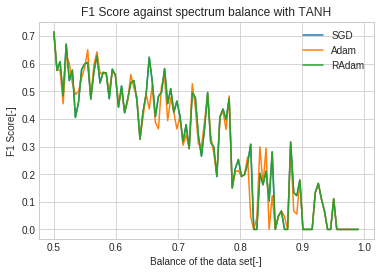

In [9]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='SGD')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, radam_f1, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.title('F1 Score against spectrum balance with TANH')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect-TANH.png')

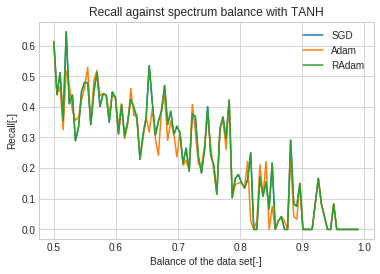

In [10]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_recall, label='SGD')
plt.plot(spects, adam_recall, label='Adam')
plt.plot(spects, radam_recall, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.title('Recall against spectrum balance with TANH')
plt.ylabel('Recall[-]')
plt.legend(loc='upper right')
plt.savefig('figures/recall-spect-TANH.png')

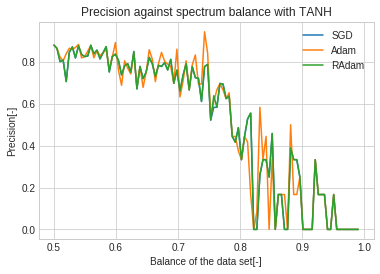

In [11]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_precision, label='SGD')
plt.plot(spects, adam_precision, label='Adam')
plt.plot(spects, radam_precision, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Precision[-]')
plt.title('Precision against spectrum balance with TANH')
plt.legend(loc='upper right')
plt.savefig('figures/precision-spect-TANH.png')

# Training and test effect

In [12]:
def run_training_benchmarking(data, epochs = 50):
    list_optimzers = ['adam', 'sgd', RAdam()]
    
    adam_val_loss = []
    radam_val_loss = []
    sgd_val_loss = []
    
    
    one_hot_enc = build_spectrum (data)

    X = one_hot_enc.drop(columns=['y'])
    y = one_hot_enc['y']
    x_keras, y_keras = build_keras (X,y)

    model = build_model(activation='selu')
    for l in list_optimzers:
        model.compile(loss='binary_crossentropy', optimizer=l, metrics=['accuracy'])
        history = model.fit(np.array(x_keras), np.array(y_keras), 
                    epochs=epochs, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose = 0)

        if l == 'adam':
            adam_val_loss.append(history.history['val_loss'])

        elif l == 'sgd':
            sgd_val_loss.append(history.history['val_loss'])
        else:
            radam_val_loss.append(history.history['val_loss'])
    return sgd_val_loss, radam_val_loss,adam_val_loss
                

In [13]:
sgd_val_loss, radam_val_loss, adam_val_loss = run_training_benchmarking(data)

Fraction of No :
0.890507404709881
Fraction of Yes :
0.10949259529011895


# Results

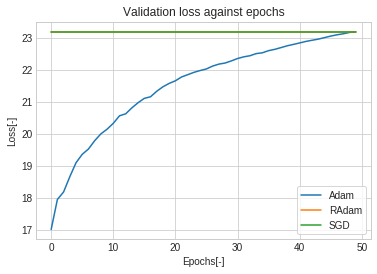

In [14]:
plt.style.use('seaborn-whitegrid')
plt.plot(adam_val_loss[0], label='Adam')
plt.plot(radam_val_loss[0], label='RAdam')
plt.plot(sgd_val_loss[0], label='SGD')
plt.xlabel('Epochs[-]')
plt.ylabel('Loss[-]')
plt.title('Validation loss against epochs')
plt.legend(loc='lower right', frameon = True)
plt.savefig('figures/loss-epochs.png')